In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import numpy.ma as ma
from geopy.distance import vincenty
import matplotlib.colors as colors

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
from mpl_toolkits import basemap
import warnings

# from salishsea_tools import (
#     nc_tools,
#     viz_tools,
# )

%matplotlib inline

In [2]:
# % create ANHA4 Bathymetry
# % this is ANHA4 full dimensions
# % this script will be repurposed to take roughness parameters and apply to 
# % the ANHA4 grid.
NX=544
NY=800
iiSub=np.arange(0,NX)
jjSub=np.arange(0,496)
#% define the region using Smith-Sandwell data - all of NX and from 0-467 for S&S

#coordfile='/ocean/jthibaul/research/data/hittite/ANHA4_coordinates.nc';
ANHAh2=np.zeros_like([NY,NX])

coordfile = nc.Dataset('/home/jacquielee/data/ANHA4_coordinates.nc')


navLon=coordfile.variables['nav_lon'][:]
navLat=coordfile.variables['nav_lat'][:]

maxLon=np.amax(navLon[:])
minLon=np.amin(navLon[:])
maxLat=np.amax(navLat[:])
minLat=np.amin(navLat[:])

# if maxLat>80.738:
#     print('out of source data range in lat')
#     print(maxLat)
#     print(minLat)
#     print(maxLon)
#     print(minLon)

In [3]:


#% set range of Smith-Sandwell data
# latRange=[minLat-0.25 min(maxLat+0.25,80.738)]
# lonRange=[minLon-0.25 maxLon+0.25]

v_swlon = sio.loadmat('/home/jacquielee/data/SS_vLON.mat', 
                       struct_as_record=False, squeeze_me=True)
v_swlat = sio.loadmat('/home/jacquielee/data/SS_vLAT.mat', 
                       struct_as_record=False, squeeze_me=True)
swlon = v_swlon['vlon'][3500:15000]
swlat = v_swlat['vlat']
swH2 = np.load('/home/jacquielee/data/hsquare_sandwell.npy')

#% linear interpolation
for i in np.arange(0,len(swlon)):
    for j in np.arange(0,len(swlat)):
        if swH2[j,i] == -1.0:
            swH2[j,i] = 0.0
        else:
            continue
        


In [15]:
swH2.min()

0.0

In [18]:
ANHAh1 = basemap.interp(swH2,swlon,swlat,navLon, navLat,masked = 0)

ANHAh0 = basemap.interp(swH2,swlon,swlat,navLon, navLat,masked=0 ,order=0)

In [19]:
mask0 = (ma.getmaskarray(ANHAh0))*1
mask1 = (ma.getmaskarray(ANHAh1))*1
ANHAh = np.zeros_like(ANHAh1,dtype=float)

for i in np.arange(0,ANHAh1[:,0].shape[0]):
    for j in np.arange(0,ANHAh1[0,:].shape[0]):
        if mask0[i,j] == mask1[i,j]:
            ANHAh[i,j] = ANHAh1[i,j]
        else:
            ANHAh[i,j] = ANHAh0[i,j]


In [22]:
 ANHAh.dump('/home/jacquielee/data/hsquare_sanha_linear.npy')

In [4]:
 ANHAh = np.load('/home/jacquielee/data/hsquare_sanha_linear.npy')

(0, 544, 0, 800)

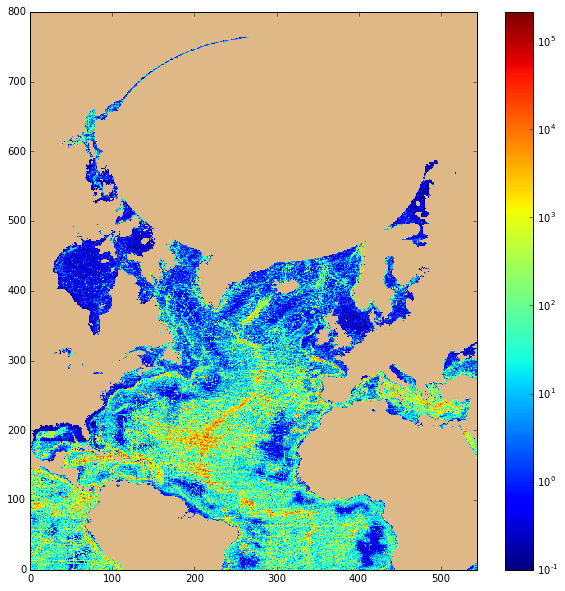

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = axes.pcolormesh(ANHAh[:,:],norm=colors.LogNorm(vmin=0.1, vmax=ANHAh.max()),cmap=cmap)
cbar = fig.colorbar(mesh,ax=axes)
plt.axis((0, ANHAh.shape[1], 0, ANHAh.shape[0]))

In [21]:
ANHAh.min()

0.0

In [5]:
grid = nc.Dataset('/home/jacquielee/data/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = grid.variables['Bathymetry'][:]
bathy = ma.masked_values(bathy[:],0)

In [6]:
anhamask = (ma.getmaskarray(bathy[:,:]))*1

In [7]:
new_grid1 = ma.array(ANHAh,mask=anhamask)
#new_grid2 = np.ma.masked_where(new_grid1[:,:] == 0,new_grid1)


In [27]:
 new_grid1.dump('/home/jacquielee/data/hsquare_sanha_linear.npy')

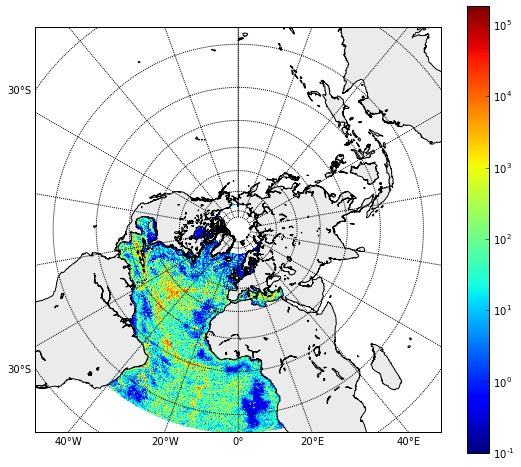

In [8]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=-20,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
cmap = plt.get_cmap('jet')
x_lons, y_lats = m(navLon,navLat)
m = m.pcolor(x_lons[:,:], y_lats[:,:],new_grid1[:,:],cmap=cmap,
             norm=colors.LogNorm(vmin=0.1, vmax=new_grid1.max()))
#cbar = fig.colorbar(m,ax=ax)
plt.colorbar(shrink=0.4)
plt.show()

In [28]:
#IBCAO for polar region

IBanha = np.load('/home/jacquielee/data/hsquare_IBCAO_linear.npy')

In [29]:
IBanha.min()

4.8148248609680896e-35

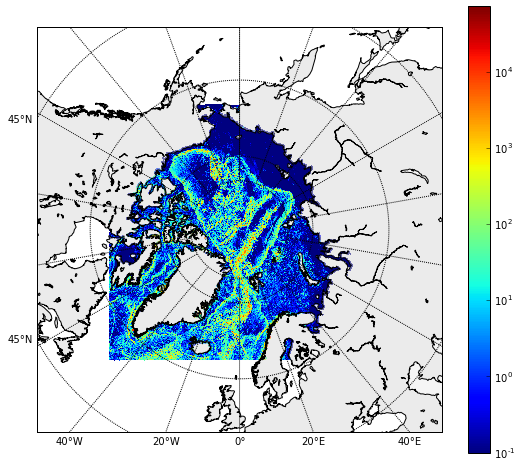

In [36]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
cmap = plt.get_cmap('jet')
x_lons, y_lats = m(navLon,navLat)
m = m.pcolor(x_lons[:,:], y_lats[:,:],IBanha[:,:],cmap=cmap,norm=colors.LogNorm(vmin=0.1, vmax=IBanha.max()))
#cbar = fig.colorbar(m,ax=ax)
plt.colorbar(shrink=0.4)
plt.show()

In [30]:
#Now the two pieces need to be added together. The IBCAO data will be taken over the S&S data where there is overlap.
#Begin by removing the mask and doing simple matrix addition
SSanha = new_grid1
ANHAh2 = np.zeros_like(SSanha,dtype=float)

i = np.arange(0,800)
j = np.arange(0,544)
#j = np.arange(0,544)
#i is y and j is x

for ii in i:
    for jj in j:
        IB = IBanha[ii,jj]
        SS = SSanha[ii,jj] 
        if ma.is_masked(IB) and ma.is_masked(SS):
            ANHAh2[ii,jj] = ma.masked
        elif ma.is_masked(IB) and (not ma.is_masked(SS)):
            ANHAh2[ii,jj] = SS
        elif (not ma.is_masked(IB)) and ma.is_masked(SS):
            ANHAh2[ii,jj] = IB
        elif (not ma.is_masked(IB)) and (not ma.is_masked(SS)):
            ANHAh2[ii,jj] = IB

In [32]:
ANHAh2.min()

0.0

In [33]:
 ANHAh2.dump('/home/jacquielee/data/h2_anhafull_unsmoothed.npy')

In [34]:
ANHAh2 = ma.filled(ANHAh2, 0.0)

(800, 544) (800, 544)


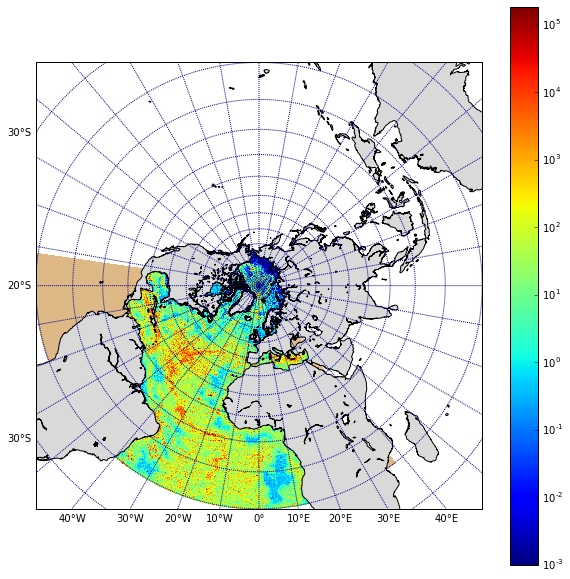

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

m = Basemap(projection='npstere',boundinglat=-20,lon_0=0,resolution='l',round=False, ax=axes)
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],color='darkblue',latmax=90)
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],color='darkblue',latmax=90)
#x_lon, y_lat = m(x[:,],y[:,])
#x_lon, y_lat = np.meshgrid(navLon, navLat)
X,Y = m(navLon, navLat)
print(X.shape,Y.shape)
m = m.pcolor(X,Y,ANHAh2,norm=colors.LogNorm(vmin=0.001, vmax=ANHAh2.max()))
cbar = fig.colorbar(m,ax=axes)

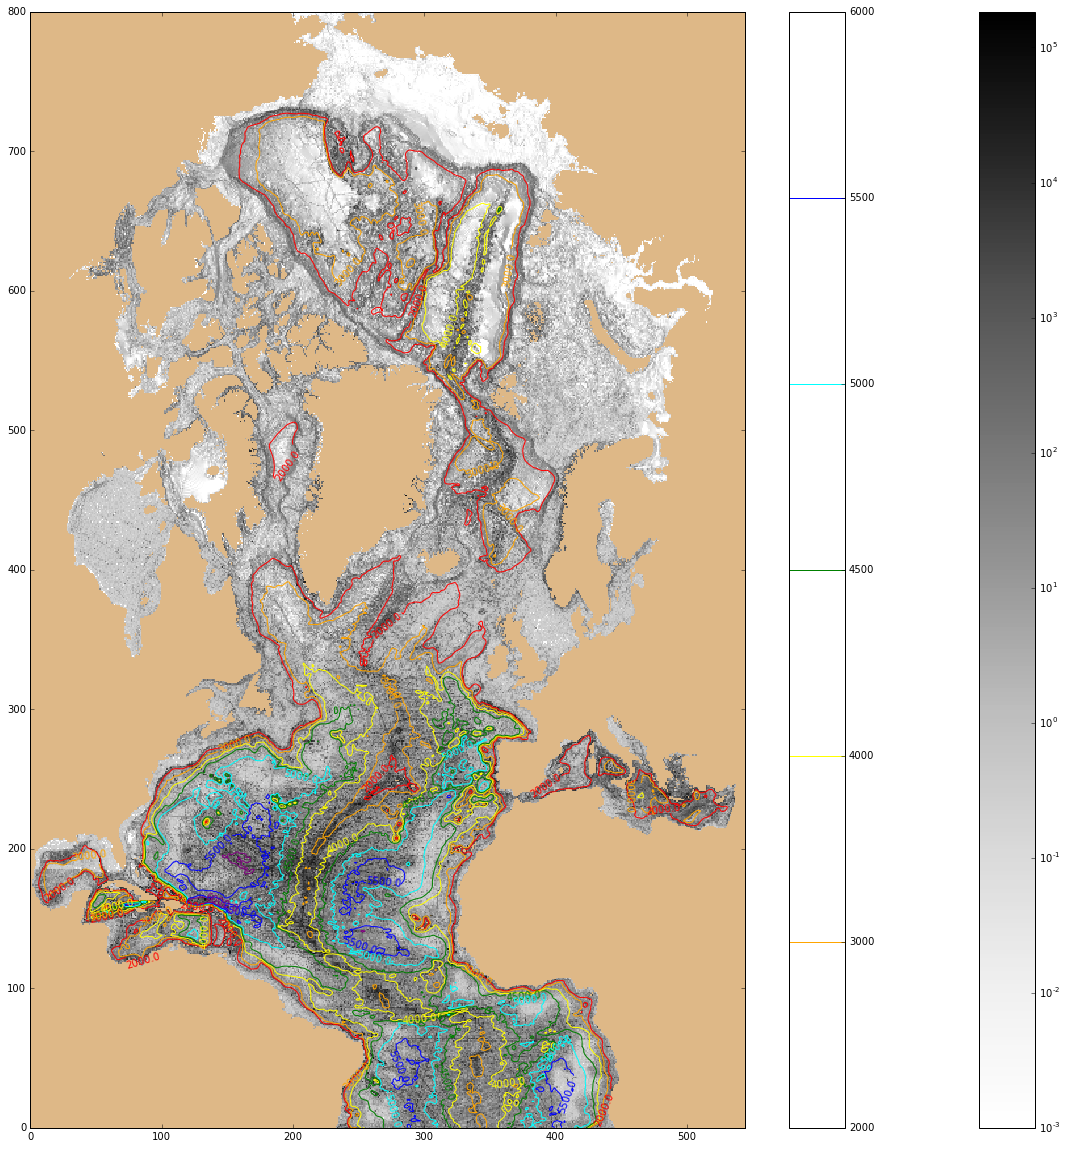

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

cmap = plt.get_cmap('Greys')
cmap.set_bad('burlywood')
mesh = axes.pcolormesh(ANHAh2[:,:],norm=colors.LogNorm(vmin=0.001, vmax=ANHAh2.max()),cmap=cmap)
cbar = fig.colorbar(mesh,ax=axes)
plt.axis((0, ANHAh2.shape[1], 0, ANHAh2.shape[0]))

clines = axes.contour(bathy,np.array([2000,3000,4000,4500,5000,5500,6000]),
                      colors=['red','orange','yellow','green','cyan','blue','purple'])
axes.clabel(clines, fmt='%1.1f')
# axes.clabel(clines2, fmt='%1.1f')
cbar1 = plt.colorbar(clines)
cbar1.add_lines(clines) 

## Move to NetCDF data file

In the plots above, we can see that the hsquare value interpolated over the ANHA4 grid roughly follows bathymetry in that we see higher hsquare values over steeper sections of the topography.

In the python blocks below the dataset is saved as a netCDF file for use in NEMo run.

In [55]:
ANHAh2.min()

for i in np.arange(0,ANHAh2[:,0].shape[0]):
    for j in np.arange(0,ANHAh2[0,:].shape[0]):
        if ma.is_masked(ANHAh2[i,j]):
            ANHAh2[i,j] = 0.0
        else:
            continue

In [57]:
ma.is_masked(ANHAh2)

False

In [47]:
print(navLon.shape,navLat.shape,ANHAh2.shape)

(800, 544) (800, 544) (800, 544)


In [48]:
ANHAh2 = np.load('/home/jacquielee/data/h2_anhafull_unsmoothed.npy')

In [68]:
from netCDF4 import Dataset

nrows = 800
ncols = 544

netfile = Dataset('/mnt/storage0/jacquielee/data/hsquare.nc', 'w', format='NETCDF3_64BIT')

In [69]:
netfile.createDimension('x', nrows)
netfile.createDimension('y', ncols)

<type 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 544

In [70]:
Lon  = netfile.createVariable('nav_lon', 'f4', ('x', 'y'))
Lat  = netfile.createVariable('nav_lat', 'f4', ('x', 'y'))
h  = netfile.createVariable('hsquare', 'f4', ('x', 'y'))

In [71]:
Lon[:,:] = navLon
Lat[:,:] = navLat
h[:,:] = ANHAh2

In [72]:
netfile.close()

In [3]:
grid = nc.Dataset('/mnt/storage0/jacquielee/data/hsquare.nc')

In [4]:
lon=grid.variables['nav_lon']
lat=grid.variables['nav_lat']
hsquare = grid.variables['hsquare']

In [7]:
hsquare = ma.masked_values(hsquare[:,:],0)

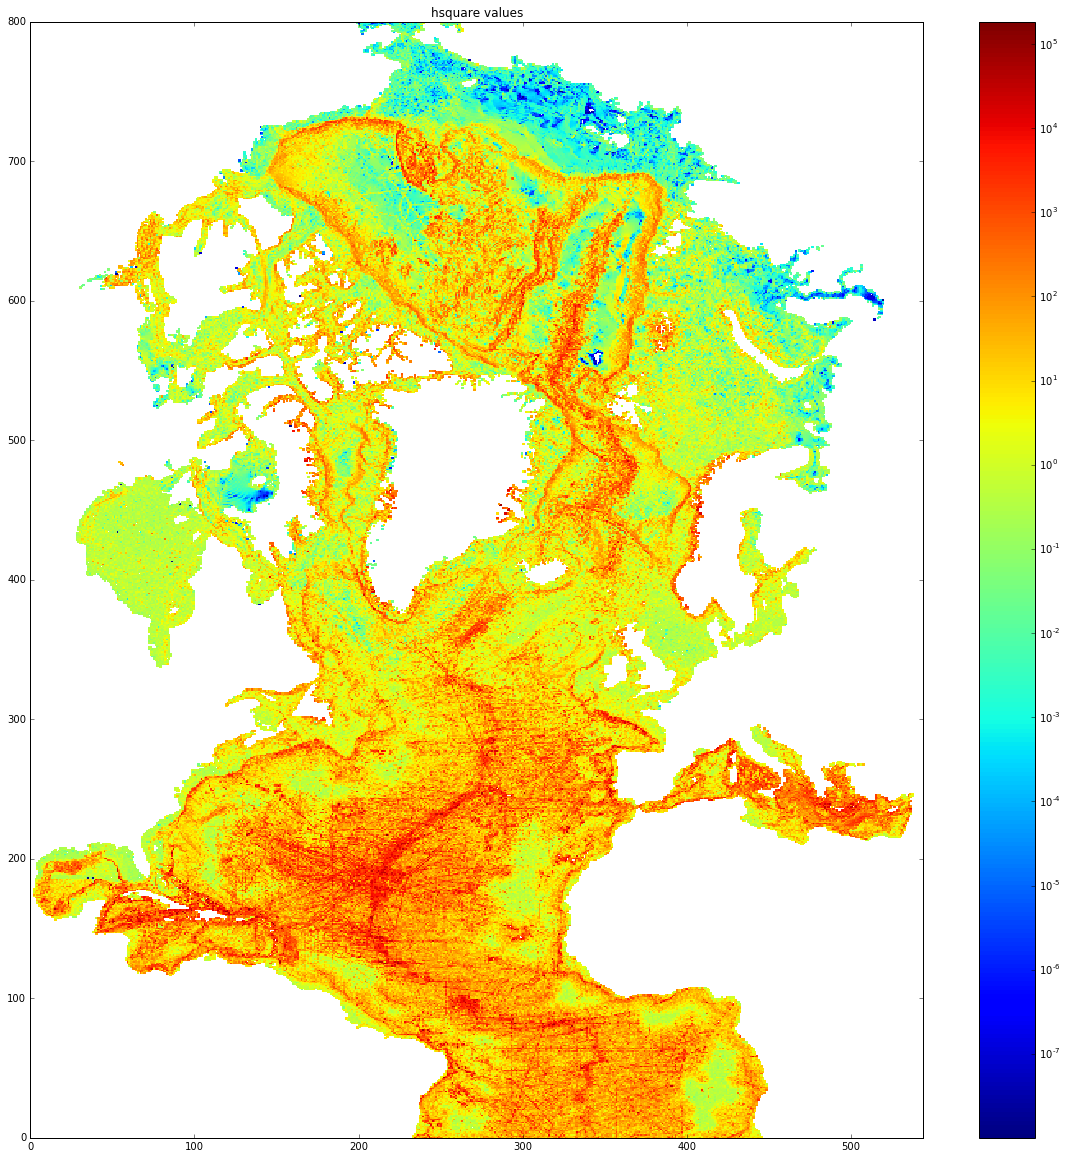

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

cmap = plt.get_cmap('Greys')
cmap.set_bad('burlywood')
mesh = axes.pcolormesh(hsquare, norm=colors.LogNorm(vmin=hsquare[:,:].min(), vmax=hsquare[:,:].max()))
cbar = fig.colorbar(mesh,ax=axes)
plt.axis((0, hsquare.shape[1], 0, hsquare.shape[0]))
axes.set_title('hsquare values')